In [1]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from matplotlib import image
import glob
import cv2
import os
import zipfile
import pyarrow as pa
import pyarrow.parquet as pq
import gc
import time
import sys

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import timeit


In [2]:
def timeit(f):
    def wrap(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        print(f'func:{f.__name__} args:[{args}, {kw}] took: {te-ts:2.4f} sec')        
        return result
    return wrap

In [3]:
@timeit
def load():
  path = pathlib.Path(r'C:\Users\eliz\w207\train_data\X_train.pq')
  table = pq.read_table(str(path))
  table = table.to_pandas().to_numpy()
  return table

X_train = load()

func:load args:[(), {}] took: 30.9218 sec


In [4]:
y_train = np.array(pd.read_csv(r'C:\Users\eliz\w207\train_data\X_labels.csv'))

y_train

array([['del'],
       ['del'],
       ['del'],
       ...,
       ['Z'],
       ['Z'],
       ['Z']], dtype=object)

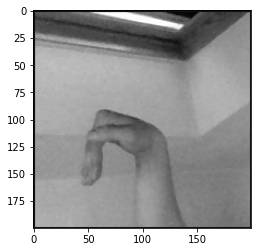

In [5]:
plt.rc('image', cmap='gray')
plt.imshow(X_train[5].reshape(200,200))
plt.show()

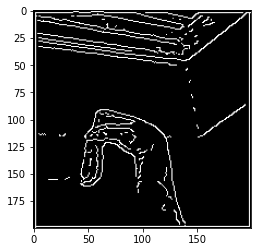

In [6]:
plt.imshow(cv2.Canny(cv2.GaussianBlur(X_train[5].reshape(200,200),(5,5),0), threshold1=35, threshold2=40))

In [7]:
@timeit
def canny_transform(array, thresh1=100, thresh2=200):
    return  np.array([cv2.Canny(i.reshape(200,200), threshold1=thresh1,threshold2=thresh2).flatten() for i in array])

X_train = canny_transform(X_train)

func:canny_transform args:[(array([[31, 32, 29, ..., 27, 33, 27],
       [30, 33, 29, ..., 28, 32, 26],
       [30, 33, 29, ..., 28, 34, 27],
       ...,
       [32, 31, 29, ..., 29, 28, 31],
       [35, 34, 31, ..., 29, 28, 30],
       [32, 33, 29, ..., 28, 28, 31]], dtype=uint8),), {}] took: 100.9915 sec


In [8]:
np.random.seed(18)

In [9]:
#Shuffle the dataset
X_train,y_train = shuffle(X_train,y_train,random_state=18)

In [10]:
# train test split to
x_train,x_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.2)

In [11]:
# deleting to clear out 4 gb in memory
del X_train

In [12]:
# @timeit
# def scaling_transform(train_data, test_data):
#     scaler = StandardScaler()
#     train = scaler.fit_transform(train_data)
#     test = scaler.transform(test_data)
#     return train, test

# x_train, x_test = scaling_transform(x_train, x_test)

In [13]:
@timeit
def pca_transform(train_data, test_data,explainability=.80, size=1000):
    pca = PCA(explainability)
    pca.fit(train_data[:size])
    train = pca.transform(train_data)
    test = pca.transform(test_data)
    print("Features Reduced to {} Principal Components".format(len(test[0])))
    return train, test

pca_train, pca_test = pca_transform(x_train, x_test)

Features Reduced to 502 Principal Components
func:pca_transform args:[(array([[  0,   0,   0, ..., 255,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ..., 255,   0,   0],
       [  0,   0,   0, ..., 255,   0,   0]], dtype=uint8), array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 255,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ..., 255,   0,   0]], dtype=uint8)), {}] took: 152.2236 sec


In [14]:
def label_encode(train_labels, test_labels):
    le = LabelEncoder()
    le.fit(train_labels)
    print(len(le.classes_))
    train = le.transform(train_labels)
    test = le.transform(test_labels)
    return train, test

train_labels, test_labels = label_encode(y_train,y_test)

29


C:\Users\Aneeq Khan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [15]:
del x_train
del x_test

In [36]:
model = xgb.XGBClassifier(learning_rate=.1)
model.fit(pca_train[:5000], train_labels[:5000])

C:\Users\Aneeq Khan\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:44:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [37]:
y_pred = model.predict(pca_test)

In [38]:
accuracy = sklearn.metrics.accuracy_score(test_labels, y_pred)
print(accuracy)

0.7545402298850574


In [19]:
xgb_2 = xgb.XGBClassifier(objective= 'multi:softmax',nthread=4,n_classes=29,seed=18)

In [20]:
params = {
    "early_stopping_rounds":[30],
    'max_depth': range (2, 10, 2),
    'n_estimators': [100],
    'learning_rate': [0.1, 0.01, 0.05]
}

In [21]:
params = {
    "early_stopping_rounds":[10],
    'learning_rate': [0.1, 0.01, 0.05]
}

In [22]:
clf = GridSearchCV(estimator=xgb_2, param_grid=params,scoring = 'roc_auc', n_jobs = 12, cv = 5,verbose=True)

In [23]:
clf.fit(pca_train[:1000],train_labels[:1000])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\Aneeq Khan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(
C:\Users\Aneeq Khan\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:38:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "n_classes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:38:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_classes=29, n_estimators=100,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None,
                

In [40]:
pd.DataFrame(pca_test).to_csv(r'C:\Users\eliz\w207\train_data\pca_test.csv',index=None)

In [41]:
pd.DataFrame(pca_train).to_csv(r'C:\Users\eliz\w207\train_data\pca_train.csv',index=None)

In [42]:
pd.DataFrame(y_train).to_csv(r'C:\Users\eliz\w207\train_data\y_train.csv',index=None)

In [43]:
pd.DataFrame(y_test).to_csv(r'C:\Users\eliz\w207\train_data\y_test.csv',index=None)

In [27]:
print(clf.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_classes=29, n_estimators=100, n_jobs=4, nthread=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=18, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              seed=18, subsample=1, ...)


In [28]:
print(clf.best_score_)

nan


In [30]:
preds = clf.predict(pca_test)

In [31]:
accuracy = sklearn.metrics.accuracy_score(test_labels, preds)
print(accuracy)

0.4838505747126437
